In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest, RFE, SelectFromModel
from collections import Counter
from sentence_transformers import SentenceTransformer
from joblib import Parallel, delayed

Read and Encode test data

In [4]:
df = pd.read_csv("test_data cs 1.csv")
pd.set_option('future.no_silent_downcasting', True)
#df = df.sample(n=2000, replace=False, random_state=42)

model = SentenceTransformer("all-MiniLM-L6-v2")  
text_embeddings = model.encode(df["text"].astype(str).tolist(), convert_to_numpy=True)
df["text"] = text_embeddings.mean(axis=1)  
screen_name_embeddings = model.encode(df["screen_name"].astype(str).tolist(), convert_to_numpy=True)
df["screen_name"] = screen_name_embeddings.mean(axis=1)  

df["verified"] = df["verified"].replace({"f": 0, "t": 1})


df["created_at"] = pd.to_datetime(df["created_at"], format="%a %b %d %H:%M:%S %Y")
df["hour"] = df["created_at"].dt.hour
df["weekday"] = df["created_at"].dt.weekday
df["month"] = df["created_at"].dt.month
df["year"] = df["created_at"].dt.year
df = df.drop(columns=["created_at"]) 

categorical_cols = ["user_lang", "lang", "time_zone", "location", "source"]
for col in categorical_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].replace(freq_map)

eyewitness_order = {"don't know": -1, "non-eyewitness": 0, "indirect-eyewitness": 1, "direct-eyewitness": 2}
df["label"] = df["label"].replace(eyewitness_order)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

num_cols = ["followers_count", "statuses_count", "friends_count", "favourites_count",
            "listed_count", "cred_score", "eye_truth", "compare_text"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Train/test split


In [5]:

X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, stratify=y, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(X_train, y_train))

GBC using all features

In [5]:
f1_scores = []
auc_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train_resampled, y_train_resampled)
    preds = gbc.predict(X_test)
    probs = gbc.predict_proba(X_test)[:, 1]  

    f1 = round(f1_score(y_test, preds, average='weighted', zero_division=1), 6)
    auc = round(roc_auc_score(y_test, probs), 6)
    f1_scores.append(f1)
    auc_scores.append(auc)

mean_f1 = round(np.mean(f1_scores), 6)
mean_auc = round(np.mean(auc_scores), 6)

print(f"Mean F1 Score: {mean_f1}")
print(f"Mean AUC Score: {mean_auc}")

Mean F1 Score: 0.946116
Mean AUC Score: 0.620502


Variance Treshold Method

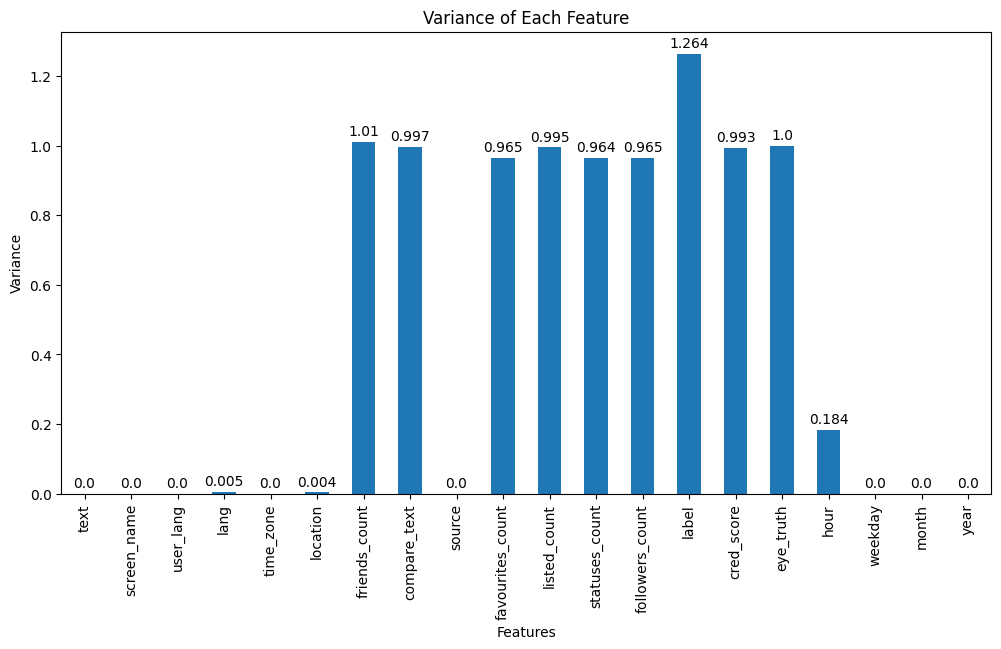

In [6]:
X_train_V, X_test_V, y_train_V, y_test_V = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
variance = X_train_V.var()
plt.figure(figsize=(12, 6))
ax = variance.plot(kind='bar')
for i, v in enumerate(variance):
    ax.text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=10)
plt.title('Variance of Each Feature')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.show()

Dropping Features with variance below 0.8

In [7]:
sel_X_train = X_train_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year", "text", "screen_name"], axis=1)
sel_X_test = X_test_V.drop(["user_lang", "lang", "time_zone", "location", "source", "hour", "weekday", "month", "year", "text", "screen_name"], axis=1)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(sel_X_train, y_train_V))

f1_scores = []
auc_scores = []

for train_index, test_index in kf.split(sel_X_train, y_train_V):
    X_train_fold, X_test_fold = sel_X_train.iloc[train_index], sel_X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train_V.iloc[train_index], y_train_V.iloc[test_index]

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train_resampled, y_train_resampled)
    preds = gbc.predict(X_test_fold)
    probs = gbc.predict_proba(X_test_fold)[:, 1]

    f1 = round(f1_score(y_test_fold, preds, average='weighted', zero_division=1), 6)
    auc = round(roc_auc_score(y_test_fold, probs), 6)
    f1_scores.append(f1)
    auc_scores.append(auc)

mean_f1 = round(sum(f1_scores) / len(f1_scores), 6)
mean_auc = round(sum(auc_scores) / len(auc_scores), 6)

print(f"Mean F1 Score: {mean_f1}")
print(f"Mean AUC Score: {mean_auc}")

Mean F1 Score: 0.803477
Mean AUC Score: 0.618556


SelectKbest feature selection (filter)

In [8]:
X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(X_train_resampled, y_train_resampled))

gbc = GradientBoostingClassifier(random_state=42)

def evaluate_kbest_kfold(k, X_train, y_train, folds):
    f1_scores = []
    auc_scores = []

    for train_index, test_index in folds:
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        selector = SelectKBest(mutual_info_classif, k=k)
        selector.fit(X_train_fold, y_train_fold)
        selected_X_train = selector.transform(X_train_fold)
        selected_X_test = selector.transform(X_test_fold)

        gbc.fit(selected_X_train, y_train_fold)
        preds = gbc.predict(selected_X_test)
        probs = gbc.predict_proba(selected_X_test)[:, 1]

        f1 = round(f1_score(y_test_fold, preds, average='weighted'), 3)
        auc = round(roc_auc_score(y_test_fold, probs), 3)
        f1_scores.append(f1)
        auc_scores.append(auc)

    return (
        round(sum(f1_scores) / len(f1_scores), 3),
        round(sum(auc_scores) / len(auc_scores), 3),
        k
    )

results = Parallel(n_jobs=-1)(
    delayed(evaluate_kbest_kfold)(k, X_train_resampled, y_train_resampled, folds) for k in range(1, 21)
)

f1_score_list, auc_score_list, feature_counts = zip(*results)

print("F1 Scores:", f1_score_list)
print("AUC Scores:", auc_score_list)
print("Feature Counts:", feature_counts)

F1 Scores: (0.728, 0.706, 0.704, 0.703, 0.89, 0.89, 0.891, 0.891, 0.892, 0.901, 0.901, 0.9, 0.899, 0.903, 0.903, 0.903, 0.903, 0.903, 0.902, 0.902)
AUC Scores: (np.float64(0.8), np.float64(0.776), np.float64(0.777), np.float64(0.777), np.float64(0.942), np.float64(0.944), np.float64(0.946), np.float64(0.946), np.float64(0.947), np.float64(0.956), np.float64(0.956), np.float64(0.956), np.float64(0.957), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959))
Feature Counts: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)


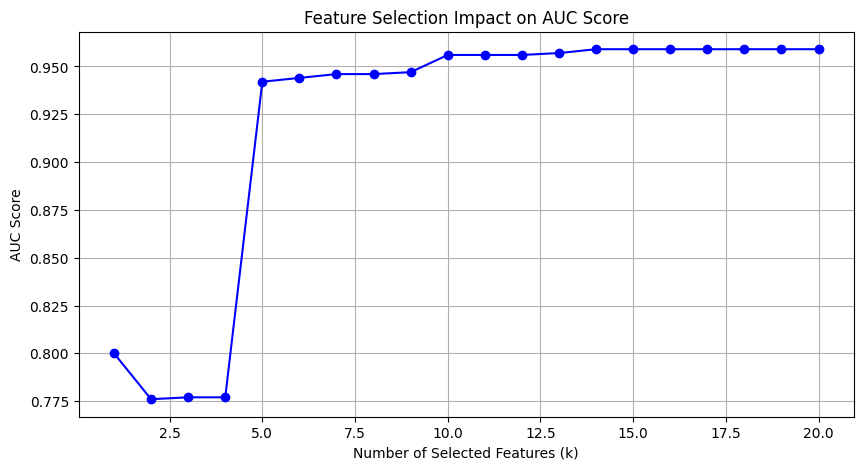

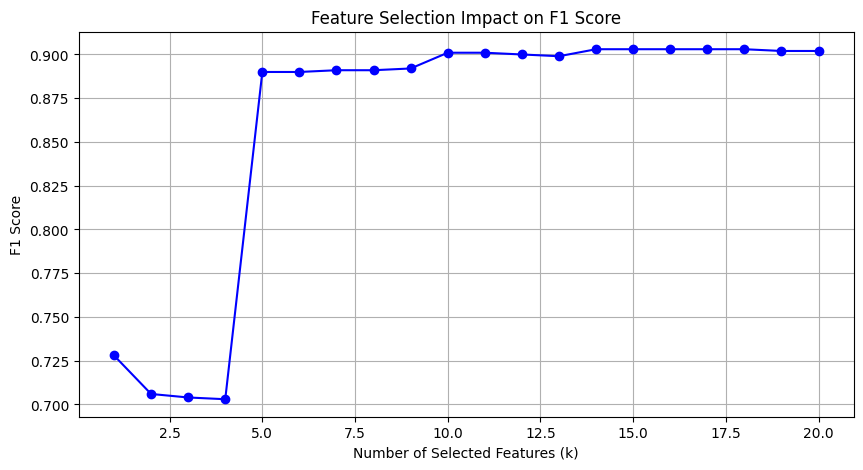

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, auc_score_list, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("AUC Score")
plt.title("Feature Selection Impact on AUC Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(feature_counts, f1_score_list, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("F1 Score")
plt.title("Feature Selection Impact on F1 Score")
plt.grid(True)
plt.show()

Recursive Feature Elimination (Wrapper)

In [10]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

def evaluate_rfe(k, X_train_V2, y_train_V2):
    f1_scores = []
    auc_scores = []
    selected_features_list = []

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_V2, y_train_V2)
    X_resampled = pd.DataFrame(X_resampled, columns=X_train_V2.columns).reset_index(drop=True)
    y_resampled = pd.Series(y_resampled).reset_index(drop=True)

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(X_resampled, y_resampled):
        X_train_fold, X_test_fold = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
        y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]

        gbc = GradientBoostingClassifier(random_state=42)
        RFE_selector = RFE(estimator=gbc, n_features_to_select=k, step=1)
        RFE_selector.fit(X_train_fold, y_train_fold)

        sel_X_train_fold = RFE_selector.transform(X_train_fold)
        sel_X_test_fold = RFE_selector.transform(X_test_fold)
        selected_features = np.where(RFE_selector.support_)[0]
        selected_features_list.append(selected_features)

        gbc.fit(sel_X_train_fold, y_train_fold)
        preds = gbc.predict(sel_X_test_fold)
        probs = gbc.predict_proba(sel_X_test_fold)[:, 1]

        f1 = round(f1_score(y_test_fold, preds, average="weighted", zero_division=1), 3)
        auc = round(roc_auc_score(y_test_fold, probs), 3)
        f1_scores.append(f1)
        auc_scores.append(auc)

    return round(np.mean(f1_scores), 3), round(np.mean(auc_scores), 3), k, selected_features_list

results = Parallel(n_jobs=-1)(
    delayed(evaluate_rfe)(k, X_train_V2, y_train_V2) for k in range(1, 21)
)

f1_score_list, auc_score_list, feature_counts, selected_features_list = zip(*results)
selected_features_dict = {k: features for k, features in zip(range(1, 21), selected_features_list)}

print("F1 Scores:", f1_score_list)
print("AUC Scores:", auc_score_list)
print("Feature Counts:", feature_counts)

F1 Scores: (np.float64(0.893), np.float64(0.903), np.float64(0.907), np.float64(0.913), np.float64(0.901), np.float64(0.898), np.float64(0.902), np.float64(0.903), np.float64(0.901), np.float64(0.903), np.float64(0.902), np.float64(0.903), np.float64(0.903), np.float64(0.902), np.float64(0.902), np.float64(0.902), np.float64(0.902), np.float64(0.902), np.float64(0.902), np.float64(0.902))
AUC Scores: (np.float64(0.915), np.float64(0.931), np.float64(0.935), np.float64(0.938), np.float64(0.954), np.float64(0.954), np.float64(0.956), np.float64(0.958), np.float64(0.958), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959), np.float64(0.959))
Feature Counts: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20)


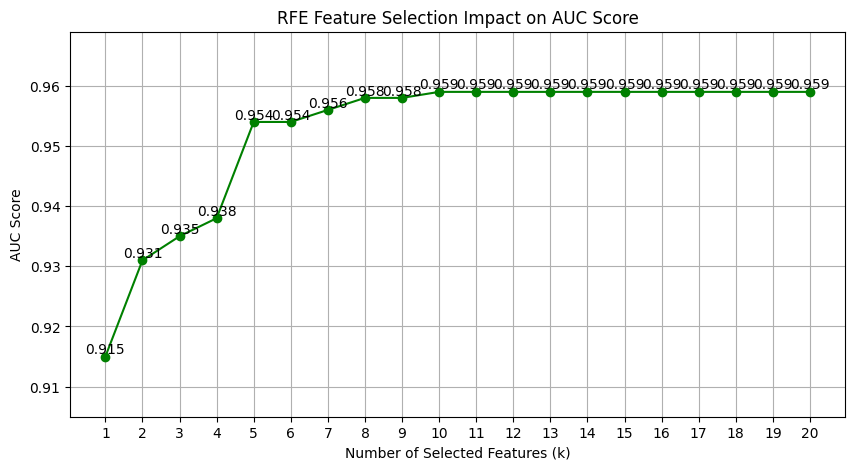

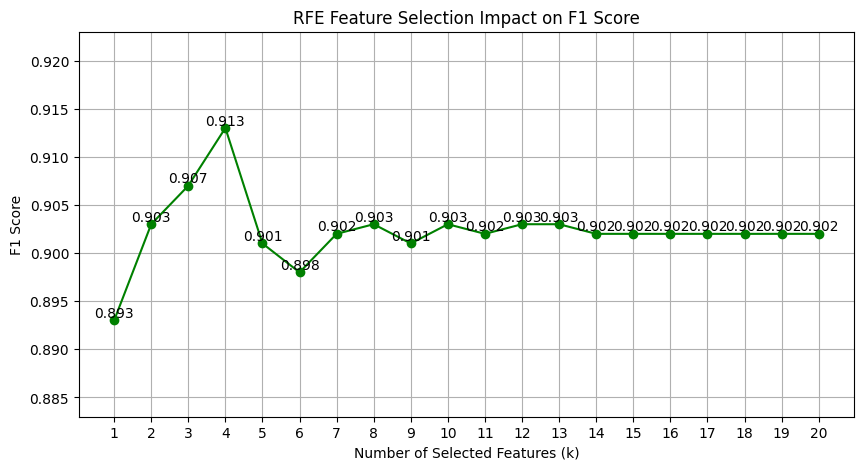

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), auc_score_list, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("AUC Score")
plt.title("RFE Feature Selection Impact on AUC Score")
plt.xticks(range(1, 21))
plt.ylim(min(auc_score_list) - 0.01, max(auc_score_list) + 0.01)
plt.grid(True)

for i, score in enumerate(auc_score_list, 1):
    plt.text(i, score, f"{score:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), f1_score_list, marker='o', linestyle='-', color='g')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("F1 Score")
plt.title("RFE Feature Selection Impact on F1 Score")
plt.xticks(range(1, 21))
plt.ylim(min(f1_score_list) - 0.01, max(f1_score_list) + 0.01)
plt.grid(True)

for i, score in enumerate(f1_score_list, 1):
    plt.text(i, score, f"{score:.3f}", ha='center', va='bottom', fontsize=10)

plt.show()


Hybrid Squirrel Dragonfly Algorithm

In [10]:
X_train_V3, X_test_V3, y_train_V3, y_test_V3 = (
    X_train.copy(),
    X_test.copy(),
    y_train.copy(),
    y_test.copy()
)


n_features = X_train_V3.shape[1]

class HSDSO:
    def __init__(self, obj_function, dim, bounds, pop_size=5, max_iter=1):
        self.obj_function = obj_function
        self.dim = dim
        self.bounds = bounds
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.population = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], (pop_size, dim))
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.best_auc = float('-inf')
        self.best_features = None 
        self.C3 = 0.5  

    def update_position_ssa(self, squirrel, best_squirrel):
        seasonal_factor = np.random.uniform(0, 1)
        return squirrel + seasonal_factor * (best_squirrel - squirrel)
    
    def update_position_da(self, dragonfly, best_dragonfly):
        separation = np.random.uniform(-1, 1, self.dim)
        alignment = (best_dragonfly - dragonfly) / 2
        cohesion = best_dragonfly - dragonfly
        return dragonfly + separation + alignment + cohesion
    
    def optimize(self):
        for _ in range(self.max_iter):
            fitness_values = np.array([self.obj_function(ind) for ind in self.population])
            best_idx = np.argmax(fitness_values[:, 0])

            if fitness_values[best_idx, 0] > self.best_fitness:
                self.best_fitness, self.best_auc = fitness_values[best_idx]
                self.best_solution = self.population[best_idx]
                feature_mask = self.best_solution[2:]
                selected_features = X_train_V3.columns[feature_mask > 0.5]
                self.best_features = list(selected_features)
            
            for i in range(self.pop_size):
                if np.random.uniform(0, 1) < self.C3:
                    self.population[i] = self.update_position_ssa(self.population[i], self.best_solution)
                else:
                    self.population[i] = self.update_position_da(self.population[i], self.best_solution)
                self.population[i] = np.clip(self.population[i], self.bounds[:, 0], self.bounds[:, 1])
        
        return self.best_solution, self.best_fitness, self.best_auc, self.best_features

def objective_function(params):
    learning_rate = params[0]
    n_estimators = int(params[1])
    feature_mask_params = params[2:]
    threshold = 0.5
    selected_mask = feature_mask_params > threshold

    if not np.any(selected_mask):
        selected_mask = np.ones_like(feature_mask_params, dtype=bool)
    selected_feature_names = X_train_V3.columns[selected_mask]
    
    print("Selected features for this evaluation:", list(selected_feature_names))
    X_selected = X_train_V3[selected_feature_names]
    
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_V3)
    X_resampled = pd.DataFrame(X_resampled, columns=selected_feature_names).reset_index(drop=True)
    y_resampled = pd.Series(y_resampled).reset_index(drop=True)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    auc_scores = []
    features_list = []  
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_resampled, y_resampled), start=1):
        X_train_fold, X_test_fold = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
        y_train_fold, y_test_fold = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]
        
        gbc = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
        gbc.fit(X_train_fold, y_train_fold)
        preds = gbc.predict(X_test_fold)
        probs = gbc.predict_proba(X_test_fold)[:, 1]
        
        f1 = f1_score(y_test_fold, preds, average='weighted', zero_division=1)
        auc = roc_auc_score(y_test_fold, probs)
        f1_scores.append(f1)
        auc_scores.append(auc)
        features_list.append(list(X_train_fold.columns))
        
        print(f"Fold {fold}: F1 Score = {f1:.4f}, AUC = {auc:.4f}")
        print(f"Features used in fold {fold}: {list(X_train_fold.columns)}\n")
    
    print("Mean F1 Score:", np.mean(f1_scores))
    print("Mean AUC Score:", np.mean(auc_scores))
    print("Features used for each fold:", features_list)
    
    return np.mean(f1_scores), np.mean(auc_scores)

bounds_hyper = np.array([[0.01, 0.2], [50, 300]])
bounds_features = np.tile(np.array([[0, 1]]), (n_features, 1))
bounds = np.concatenate([bounds_hyper, bounds_features], axis=0)

hs_dso = HSDSO(obj_function=objective_function, dim=2 + n_features, bounds=bounds, pop_size=5, max_iter=1)
best_params, best_f1, best_auc, best_features = hs_dso.optimize()

print("\n--- Optimization Results ---")
print(f"Optimized Learning Rate: {best_params[0]:.4f}")
print(f"Optimized n_estimators: {int(best_params[1])}")
print(f"Best F1 Score: {best_f1:.6f}")
print(f"Best AUC Score: {best_auc:.6f}")
print(f"Optimized Selected Features: {best_features}")


Selected features for this evaluation: ['screen_name', 'user_lang', 'time_zone', 'location', 'compare_text', 'eye_truth', 'year']
Fold 1: F1 Score = 0.7059, AUC = 0.8068
Features used in fold 1: ['screen_name', 'user_lang', 'time_zone', 'location', 'compare_text', 'eye_truth', 'year']

Fold 2: F1 Score = 0.7156, AUC = 0.8100
Features used in fold 2: ['screen_name', 'user_lang', 'time_zone', 'location', 'compare_text', 'eye_truth', 'year']

Fold 3: F1 Score = 0.7182, AUC = 0.8103
Features used in fold 3: ['screen_name', 'user_lang', 'time_zone', 'location', 'compare_text', 'eye_truth', 'year']

Fold 4: F1 Score = 0.7168, AUC = 0.8111
Features used in fold 4: ['screen_name', 'user_lang', 'time_zone', 'location', 'compare_text', 'eye_truth', 'year']

Fold 5: F1 Score = 0.7154, AUC = 0.8110
Features used in fold 5: ['screen_name', 'user_lang', 'time_zone', 'location', 'compare_text', 'eye_truth', 'year']

Mean F1 Score: 0.7143719252778427
Mean AUC Score: 0.809870378161812
Features used for